In [1]:
import os
import bigframes.pandas as bf
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import time
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from google.cloud import bigquery

In [2]:
bf.options.bigquery.project = 'credit-business-on-demand-9fd5'

In [3]:
query_tomado_kgiro = f""" SELECT * FROM `dataplatform-nonprd.credit_negocios.documento_kgiro_estudo_vencedores`"""
df_tomado_kgiro = bf.read_gbq(query_tomado_kgiro)
base_tomado_kgiro = df_tomado_kgiro.to_pandas()

In [4]:
base_tomado_kgiro['RootDocumentNumber'] = base_tomado_kgiro['RootDocumentNumber'].astype(int)

In [5]:
'''
df_ = pd.read_csv('document_winners.csv')
df_['RootDocument'] = df_['document'].astype(str).str[:8]
df_ = df_.drop_duplicates(['RootDocument'])
df = df_[['RootDocument']]

#%% Exportacao
client = bigquery.Client(project = 'dataplatform-prd')

table_name = 'credit_negocios.document_winners'

job_config = bigquery.LoadJobConfig(write_disposition = "WRITE_TRUNCATE")
job = client.load_table_from_dataframe(df, table_name, job_config = job_config)
'''

'\ndf_ = pd.read_csv(\'document_winners.csv\')\ndf_[\'RootDocument\'] = df_[\'document\'].astype(str).str[:8]\ndf_ = df_.drop_duplicates([\'RootDocument\'])\ndf = df_[[\'RootDocument\']]\n\n#%% Exportacao\nclient = bigquery.Client(project = \'dataplatform-prd\')\n\ntable_name = \'credit_negocios.document_winners\'\n\njob_config = bigquery.LoadJobConfig(write_disposition = "WRITE_TRUNCATE")\njob = client.load_table_from_dataframe(df, table_name, job_config = job_config)\n'

In [6]:
base_w = pd.read_csv('document_winners.csv')

In [7]:
base_w['RootDocumentNumber'] = base_w['document'].astype(str).str[:8].astype(int)

In [8]:
ls_document_w = base_w['RootDocumentNumber'].unique().tolist()

In [9]:
base_tomado_kgiro_w = base_tomado_kgiro[base_tomado_kgiro['RootDocumentNumber'].isin(ls_document_w)]

In [10]:
base_tomado_kgiro_w = base_tomado_kgiro_w.sort_values(by=['RootDocumentNumber', 'ReferenceMonth'])

In [11]:
base_tomado_kgiro_w['var_pct_valorTomadoKGiro'] = (
    base_tomado_kgiro_w
    .groupby('RootDocumentNumber')['valorTomadoKGiro']
    .pct_change())
base_tomado_kgiro_w['diff_valorTomadoKGiro'] = (
    base_tomado_kgiro_w
    .groupby('RootDocumentNumber')['valorTomadoKGiro']
    .diff())

In [12]:
base_tomado_kgiro_w['check_var_pct_valorTomadoKGiro'] = np.where(
    (base_tomado_kgiro_w['var_pct_valorTomadoKGiro'] > 0.1) &
    (~np.isinf(base_tomado_kgiro_w['var_pct_valorTomadoKGiro']) &
    (base_tomado_kgiro_w['var_pct_valorTomadoKGiro'].notna())),
    1, 0)

In [13]:
query_rosa_ventos = f""" SELECT * FROM `dataplatform-prd.credit_business_intelligence.vw_clientes_rosa_ventos`"""
df_rosa_ventos = bf.read_gbq(query_rosa_ventos)
base_rosa_ventos = df_rosa_ventos.to_pandas()

In [14]:
base_rosa_ventos['RootDocumentNumber'] = base_rosa_ventos['documento'].str[:8].astype(int)

In [15]:
base_rosa_ventos_w = base_rosa_ventos[base_rosa_ventos['RootDocumentNumber'].isin(ls_document_w)]

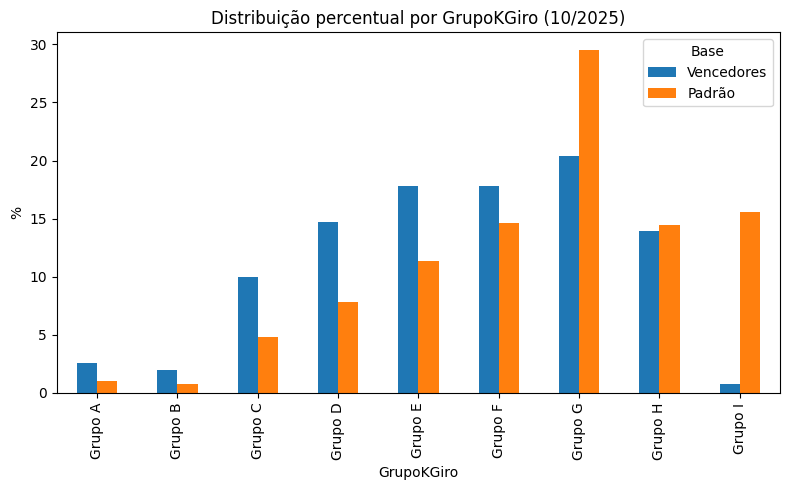

In [16]:
# Create value count percentages for both
df1 = base_rosa_ventos_w['GrupoKGiro'].value_counts(normalize=True) * 100
df2 = base_rosa_ventos['GrupoKGiro'].value_counts(normalize=True) * 100

# Combine them into one DataFrame
df_plot = pd.DataFrame({
    'Vencedores': df1,
    'Padrão': df2
}).fillna(0)  # fill missing categories with 0

# Plot grouped bars
df_plot.plot(kind='bar', figsize=(8,5))
plt.title('Distribuição percentual por GrupoKGiro (10/2025)')
plt.ylabel('%')
plt.xlabel('GrupoKGiro')
plt.legend(title='Base')
plt.tight_layout()
plt.show()

In [17]:
base_kgiro_rosas = base_tomado_kgiro_w.merge(base_rosa_ventos_w,how='left',on=['RootDocumentNumber']).dropna(subset=['GrupoKGiro'])

In [18]:
base_kgiro_rosas[base_kgiro_rosas['check_var_pct_valorTomadoKGiro'] == 1]['diff_valorTomadoKGiro'].sum()

314436237.78999996

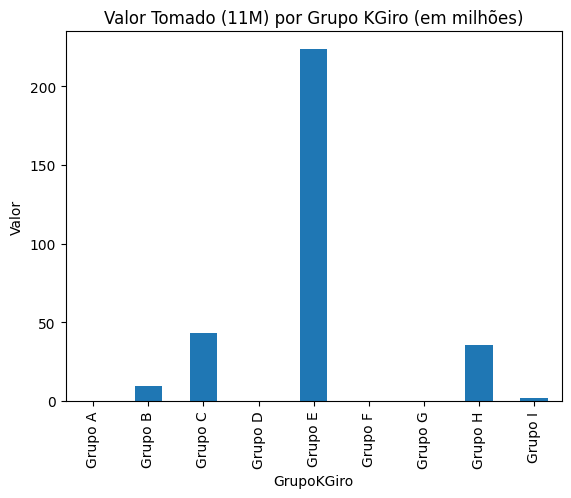

In [19]:
(
    base_kgiro_rosas[base_kgiro_rosas['check_var_pct_valorTomadoKGiro'] == 1]
    .groupby(['GrupoKGiro'])
    .agg(valor_tomado_KGiro=('diff_valorTomadoKGiro', 'sum'))
    .assign(valor_tomado_KGiro=lambda x: x['valor_tomado_KGiro'] / 1_000_000)
    .plot(kind='bar', legend=False)
)

plt.ylabel('Valor')
plt.title('Valor Tomado (11M) por Grupo KGiro (em milhões)')
plt.show()

In [20]:
query_elegibilidade = f""" SELECT * FROM `dataplatform-nonprd.credit_negocios.elegibilidade_estudo_vencedores`"""
df_elegibilidade = bf.read_gbq(query_elegibilidade)
base_elegibilidade = df_elegibilidade.to_pandas()

In [21]:
base_elegibilidade.sort_values(by=['document','data_application_score_processing_at'],inplace=True)

In [22]:
base_elegibilidade_res = base_elegibilidade.groupby(['document']).last().reset_index()

In [23]:
base_elegibilidade_res['RootDocumentNumber'] = base_elegibilidade_res['document'].str[:8].astype(int)

In [24]:
base_elegibilidade_res_w = base_elegibilidade_res[base_elegibilidade_res['RootDocumentNumber'].isin(ls_document_w)]

In [25]:
TOP_N = 15
SCALE_MILLIONS = True  # opcional

# 1) Top N motivos
motivos_abs = base_elegibilidade_res_w['reasons_not_elegible_translation'].value_counts()
top_motivos = motivos_abs.head(TOP_N).index
motivos_pct = (motivos_abs / motivos_abs.sum() * 100).loc[top_motivos]

# 2) Soma de diff_valorTomadoKGiro por motivo (com filtro)
df_reason_docs = (
    base_elegibilidade_res_w.loc[
        base_elegibilidade_res_w['reasons_not_elegible_translation'].isin(top_motivos),
        ['reasons_not_elegible_translation', 'RootDocumentNumber']
    ]
    .drop_duplicates()
)

kgiro_ok = base_tomado_kgiro_w.loc[
    base_tomado_kgiro_w['check_var_pct_valorTomadoKGiro'] == 1,
    ['RootDocumentNumber', 'diff_valorTomadoKGiro']
]

val_sum = (
    df_reason_docs
    .merge(kgiro_ok, on='RootDocumentNumber', how='left')
    .groupby('reasons_not_elegible_translation', dropna=False)['diff_valorTomadoKGiro']
    .sum(min_count=1)
    .reindex(top_motivos)
    .fillna(0.0)
)

# 3) Monta a tabela base (ordem preservada)
tabela = pd.DataFrame({
    'Quantidade': motivos_abs.loc[top_motivos].astype('int64'),
    'Percentual': motivos_pct.astype('float'),
    'Valor_Soma': val_sum.astype('float')
})
tabela.index.name = 'Motivo'  # só para ficar bonito

# 4) Coluna de exibição em milhões + rename (se for usar no gráfico)
if SCALE_MILLIONS:
    tabela['Valor_Soma_exib'] = (tabela['Valor_Soma'] / 1_000_000).astype('float')
    # se quiser usar o nome final no heatmap:
    tabela = tabela.rename(columns={'Valor_Soma_exib': 'Valor KGiro'})
    valor_col_plot = 'Valor KGiro'
else:
    valor_col_plot = 'Valor_Soma'

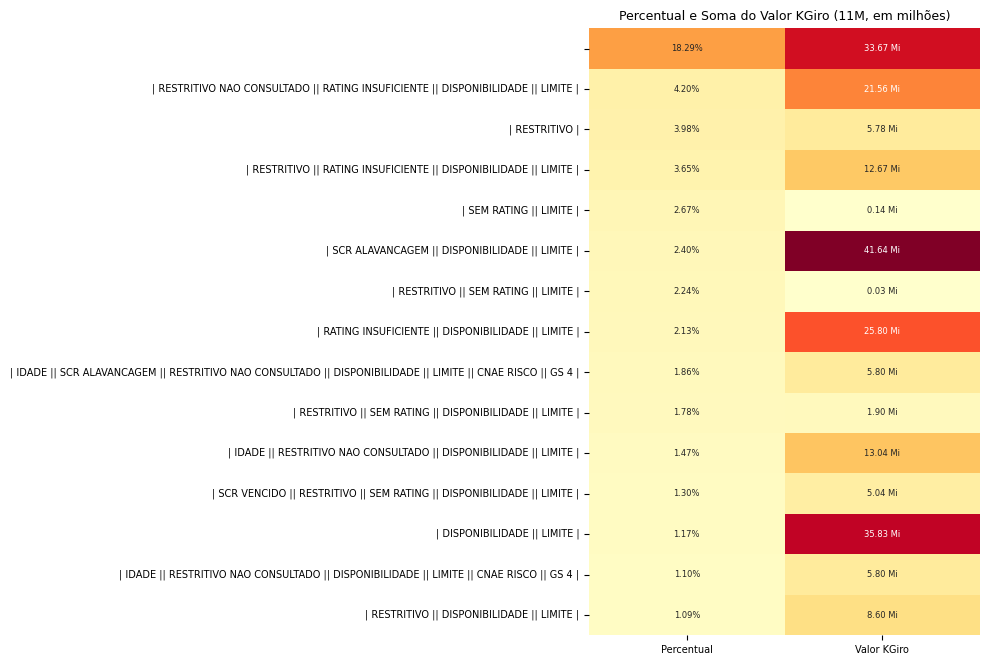

In [26]:
# ==========================
# 4) Heatmap-tabela: Razões x (Percentual, Soma)
# ==========================
data_plot = tabela[['Percentual', valor_col_plot]].copy()

# Garante que ambas as colunas são numéricas
for c in data_plot.columns:
    data_plot[c] = pd.to_numeric(data_plot[c], errors='coerce')

# (Opcional) se houver NaN, substitui por 0 para o heatmap
data_plot = data_plot.fillna(0.0)

# Labels personalizados por coluna (strings apenas para anotação)
labels = pd.DataFrame(index=data_plot.index, columns=data_plot.columns)
labels['Percentual'] = data_plot['Percentual'].map(lambda x: f"{x:.2f}%")

if SCALE_MILLIONS:
    labels[valor_col_plot] = data_plot[valor_col_plot].map(lambda x: f"{x:.2f} Mi")
else:
    labels[valor_col_plot] = data_plot[valor_col_plot].map(
        lambda x: f"{x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')
    )

plt.figure(figsize=(10, max(6, TOP_N * 0.45)))

sns.heatmap(
    data_plot.astype(float),
    annot=labels.to_numpy(),
    fmt="",
    cmap='YlOrRd',
    cbar=False,               # remove a escala da cor
    yticklabels=data_plot.index,
    annot_kws={"size": 6},    # texto dentro das células menor
)

plt.title('Percentual e Soma do Valor KGiro (11M, em milhões)', fontsize=9)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
plt.show()



In [27]:
temporaria = base_kgiro_rosas[base_kgiro_rosas['RootDocumentNumber'].isin(document_rating)]
temporaria[(temporaria['check_var_pct_valorTomadoKGiro'] == 1)]['diff_valorTomadoKGiro'].sum()

NameError: name 'document_rating' is not defined

In [33]:
len(document_rating)

2453

In [30]:
document_rating = base_elegibilidade_res_w[base_elegibilidade_res_w['reasons_not_elegible_translation'].isin(['| SCR ALAVANCAGEM || DISPONIBILIDADE || LIMITE |','| DISPONIBILIDADE || LIMITE |'])]['RootDocumentNumber']

In [28]:
query_rating = f""" SELECT * FROM `dataplatform-nonprd.credit_negocios.rating_vencedores`"""
df_rating = bf.read_gbq(query_rating)
base_rating = df_rating.to_pandas()

In [29]:
base_rating['RootDocumentNumber'] = base_rating['RootDocumentNumber'].astype(int)

In [ ]:
base_rating[base_rating['RootDocumentNumber'].isin(document_rating)]['ModelVersion'].value_counts()

In [32]:
base_rating[(base_rating['RootDocumentNumber'].isin(document_rating))&(base_rating['ModelVersion'] != 'CSv6.1/14')]['CreditRating'].value_counts()

CreditRating
10.0: 855-1000    1911
10.0: 802-1000    1807
10.0: 832-1000    1741
5.0: 515-675       916
5.5: 344-650       787
6.5: 675-742       777
9.5: 906-1000      744
8.0: 778-817       693
8.5: 817-855       670
6.5: 650-744       626
7.0: 742-778       589
7.5: 744-802       527
3.5: 336-515       479
5.0: 662-876       387
10.0: 860-1000     360
9.5: 764-832       352
6.5: 785-864       301
8.0: 864-906       299
4.5: 581-704       271
8.5: 705-764       248
7.5: 585-705       245
5.5: 704-785       242
10.0: 940-1000     228
6.0: 413-585       203
7.5: 901-940       202
1.5: 0-336         168
4.0: 422-662       135
9.5: 794-860       129
3.5: 470-581       109
3.5: 232-344       106
8.5: 733-794        96
7.0: 640-733        92
4.0: 157-413        91
5.5: 547-640        88
6.0: 876-901        83
6.0: 615-683        72
6.5: 601-708        65
1.5: 0-232          60
2.5: 311-470        54
4.5: 462-547        53
10.0: 811-1000      53
3.5: 325-462        44
2.5: 277-422        4

In [34]:
base_rating_w = base_elegibilidade_res_w.merge(base_rating,how='left',left_on=['RootDocumentNumber','data_application_score_processing_at'],right_on=['RootDocumentNumber','ProcessingDate'])

In [36]:
base_rating_w[(base_rating_w['RootDocumentNumber'].isin(document_rating))&(base_rating_w['ModelVersion'] != 'CSv6.1/14')]['CreditRating'].value_counts()

CreditRating
10.0: 802-1000    278
10.0: 855-1000    243
10.0: 832-1000    238
5.5: 344-650      109
5.0: 515-675      106
6.5: 650-744      102
9.5: 906-1000      95
6.5: 675-742       85
8.0: 778-817       82
7.0: 742-778       77
8.5: 817-855       75
7.5: 744-802       62
3.5: 336-515       55
10.0: 860-1000     51
5.0: 662-876       47
8.0: 864-906       40
9.5: 764-832       36
8.5: 705-764       36
6.5: 785-864       35
7.5: 585-705       32
4.5: 581-704       31
7.5: 901-940       27
10.0: 940-1000     25
6.0: 413-585       23
5.5: 704-785       22
1.5: 0-336         17
3.5: 232-344       17
4.0: 422-662       14
9.5: 794-860       13
8.5: 733-794       12
3.5: 470-581       12
5.5: 547-640       11
10.0: 742-1001     10
4.0: 157-413       10
6.0: 615-683       10
6.5: 601-708        9
10.0: 811-1000      8
7.0: 640-733        8
1.5: 0-232          6
2.5: 311-470        6
2.5: 277-422        6
6.0: 876-901        5
4.5: 462-547        5
8.0: 725-787        4
10.0: 787-1000     

In [40]:
base_rating_10 = base_rating_w[(base_rating_w['RootDocumentNumber'].isin(document_rating))&(base_rating_w['ModelVersion'] != 'CSv6.1/14')]

In [45]:
base_rating_10['CreditRating'] = pd.to_numeric(base_rating_10['CreditRating'].str[:2])

AttributeError: Can only use .str accessor with string values!

In [46]:
base_rating_10 = base_rating_10[base_rating_10['CreditRating'] == 10]

In [50]:
base_rating_10_apto = base_rating_10[base_rating_10['reasons_not_elegible_translation'] == '']

In [51]:
document_rating = base_rating_10_apto[base_rating_10_apto['CreditRating'] == 10]['RootDocumentNumber']

In [52]:
document_rating

0        10074151
4        10193549
8        10209210
9        10212994
16       10239725
           ...   
13397    96224548
13398    96341060
13400    96576962
13405    97329239
13407    97384804
Name: RootDocumentNumber, Length: 742, dtype: int64

In [ ]:
base_rating_w[base_rating_w['CreditRating'] == '0.0: IsTPVUpperMedium']['rating_value'].value_counts()

In [ ]:
(base_rating_w['CreditRating'].value_counts(normalize=True)*100).head(20)

In [ ]:
base_rating_w[base_rating_w['CreditRating'] == '0.0: IsTPVUpperMedium']['reasons_not_elegible_translation'].value_counts().head(20)

In [ ]:
base_rating_w['CreditRating_I'] = pd.to_numeric(base_rating_w['CreditRating'].str[:2])

In [ ]:
document_rating = base_rating_w[base_rating_w['CreditRating_I'] == 10]['RootDocumentNumber']

In [53]:
df = pd.DataFrame(document_rating).astype(str).rename(columns={'RootDocumentNumber':'RootDocument'})
client = bigquery.Client(project = 'dataplatform-prd')

table_name = 'credit_negocios.document_winners'

job_config = bigquery.LoadJobConfig(write_disposition = "WRITE_TRUNCATE")
job = client.load_table_from_dataframe(df, table_name, job_config = job_config)

In [ ]:
base_rating['CreditRating'].value_counts().head(20)